Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [X] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [X] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

     |████████████████████████████████| 92kB 6.0MB/s 
     |████████████████████████████████| 133kB 15.4MB/s 
     |████████████████████████████████| 7.1MB 2.3MB/s 
     |████████████████████████████████| 614kB 38.7MB/s 
     |████████████████████████████████| 225kB 44.1MB/s 
     |████████████████████████████████| 768kB 50.4MB/s 
     |████████████████████████████████| 194kB 31.8MB/s 
     |████████████████████████████████| 51kB 23.1MB/s 
     |████████████████████████████████| 737kB 50.7MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145035 sha256=ab80e808002931d33fa24efc23181cfc19f664cafd22057edfaa04cb6e790167
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27084 sha256=4f3c3bba8dd362409dc6b5fdab2d45b7da4b37dfcff7f956e60a4e3df05dcdfa
  Stored i

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [4]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,FASHION,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,FASHION,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [0]:
pd.options.display.float_format = '{:.0f}'.format

In [12]:
df.describe()

,BOROUGH,BLOCK,LOT,EASE-MENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,23040,23040,23040,0,23039,23039,23039,23039,23039,23005,23040,23040
mean,3,4459,354,nan,10791,2,0,2,3509,1820,2,1328133
std,1,3713,628,nan,1103,10,6,12,22186,488,1,10253944
min,1,1,1,nan,0,0,-148,0,0,0,1,0
25%,2,1341,22,nan,10306,0,0,1,494,1920,1,0
50%,3,3546,49,nan,11211,1,0,1,1356,1940,1,455000
75%,4,6674,375,nan,11360,2,0,2,2280,1965,2,875000
max,5,16350,9057,nan,11697,750,570,755,1303935,2019,4,850000000


In [93]:
df.describe(exclude='number')

,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,23040,23040,23039,23039,23040,5201,22987,23040,23040
unique,252,44,10,146,22691,1724,3652,147,120
top,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,D4,100 JEROME STREET,4,0,D4,2019-01-24 00:00:00
freq,685,5061,11071,3408,6,99,7500,3408,480
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-30 00:00:00


In [13]:
df.dtypes

BOROUGH                                    int64
NEIGHBORHOOD                              object
BUILDING_CLASS_CATEGORY                   object
TAX_CLASS_AT_PRESENT                      object
BLOCK                                      int64
LOT                                        int64
EASE-MENT                                float64
BUILDING_CLASS_AT_PRESENT                 object
ADDRESS                                   object
APARTMENT_NUMBER                          object
ZIP_CODE                                 float64
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                          object
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                               float64
TAX_CLASS_AT_TIME_OF_SALE                  int64
BUILDING_CLASS_AT_TIME_OF_SALE            object
SALE_PRICE                                 int64
SALE_DATE           

In [14]:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'],infer_datetime_format=True)
df.dtypes

BOROUGH                                    int64
NEIGHBORHOOD                              object
BUILDING_CLASS_CATEGORY                   object
TAX_CLASS_AT_PRESENT                      object
BLOCK                                      int64
LOT                                        int64
EASE-MENT                                float64
BUILDING_CLASS_AT_PRESENT                 object
ADDRESS                                   object
APARTMENT_NUMBER                          object
ZIP_CODE                                 float64
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                          object
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                               float64
TAX_CLASS_AT_TIME_OF_SALE                  int64
BUILDING_CLASS_AT_TIME_OF_SALE            object
SALE_PRICE                                 int64
SALE_DATE           

In [15]:
df.SALE_DATE.dt.month.value_counts()

1    6464
3    6105
2    5598
4    4873
Name: SALE_DATE, dtype: int64

In [16]:
train = df[df.SALE_DATE.dt.month < 4]
test = df[df.SALE_DATE.dt.month == 4]
train.shape,test.shape

((18167, 21), (4873, 21))

In [26]:
train.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,nan,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011,1,0,1,"10,733",1979,2007,2,R4,0,2019-01-01
1,1,FASHION,21 OFFICE BUILDINGS,4,812,68,nan,O5,144 WEST 37TH STREET,NaN,10018,0,6,6,"2,962",15435,1920,4,O5,0,2019-01-01
2,1,FASHION,21 OFFICE BUILDINGS,4,839,69,nan,O5,40 WEST 38TH STREET,NaN,10018,0,7,7,"2,074",11332,1930,4,O5,0,2019-01-01
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,nan,R4,"1 SHERIDAN SQUARE, 8C",8C,10014,1,0,1,0,500,0,2,R4,0,2019-01-01
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,nan,R1,"20 EAST 65TH STREET, B",B,10065,1,0,1,0,6406,0,2,R1,0,2019-01-01


In [32]:
train.ZIP_CODE.nunique()

184

In [35]:
train.RESIDENTIAL_UNITS.nunique()

75

In [36]:
train.COMMERCIAL_UNITS.nunique()

34

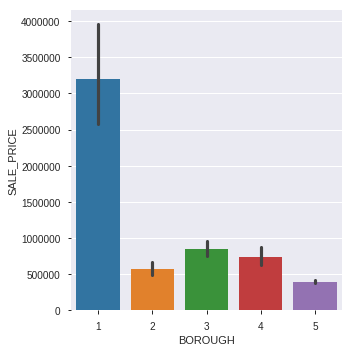

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(x='BOROUGH',y='SALE_PRICE',data=train,kind='bar')

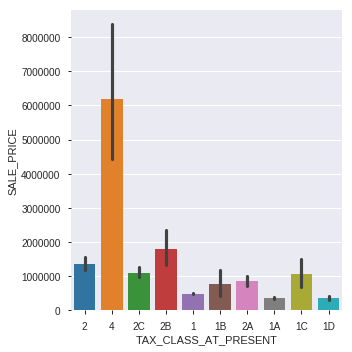

In [30]:
sns.catplot(x='TAX_CLASS_AT_PRESENT',y='SALE_PRICE',data=train,kind='bar')

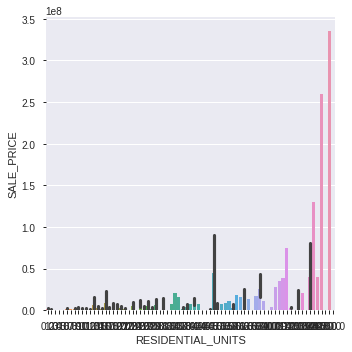

In [33]:
sns.catplot(x='RESIDENTIAL_UNITS',y='SALE_PRICE',data=train,kind='bar')

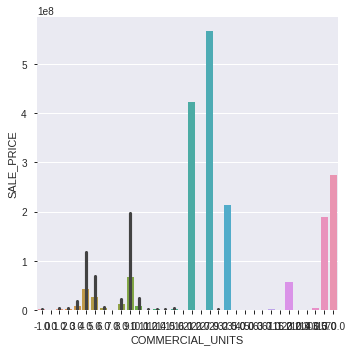

In [37]:
sns.catplot(x='COMMERCIAL_UNITS',y='SALE_PRICE',data=train,kind='bar')

In [85]:
def com(li):
  li = str(li).replace(',','')
  return(li)
train['LAND_SQUARE_FEET'] = train.LAND_SQUARE_FEET.apply(com)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [89]:
train['LAND_SQUARE_FEET'] = train.LAND_SQUARE_FEET.astype(float)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [90]:
train.dtypes

BOROUGH                                    int64
NEIGHBORHOOD                              object
BUILDING_CLASS_CATEGORY                   object
TAX_CLASS_AT_PRESENT                      object
BLOCK                                      int64
LOT                                        int64
EASE-MENT                                float64
BUILDING_CLASS_AT_PRESENT                 object
ADDRESS                                   object
APARTMENT_NUMBER                          object
ZIP_CODE                                 float64
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                         float64
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                               float64
TAX_CLASS_AT_TIME_OF_SALE                  int64
BUILDING_CLASS_AT_TIME_OF_SALE            object
SALE_PRICE                                 int64
SALE_DATE           

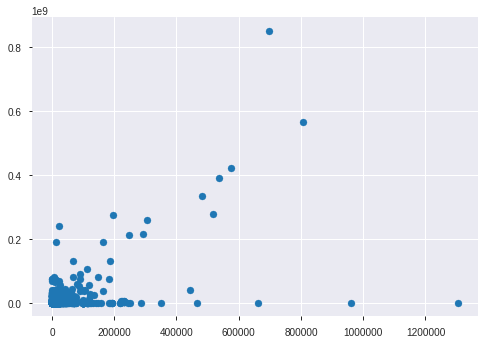

In [74]:
plt.scatter(train['GROSS_SQUARE_FEET'],train['SALE_PRICE'])

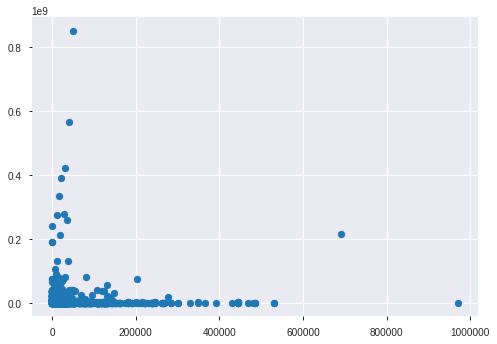

In [91]:
plt.scatter(train['LAND_SQUARE_FEET'],train['SALE_PRICE'])